# Import Libraries

In [1]:
import numpy as np # linear algebra
import os
from tensorflow import keras
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

# Data

In [2]:
path = '/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset'

In [3]:
labels = ['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']

# Preprocess Data

In [5]:
print("pre-processing data\n")

image_data=[]
label_data=[]
image_size=150

for i in labels:
    data_path=os.path.join("/kaggle/input/grapevine-leaves-image-dataset/","Grapevine_Leaves_Image_Dataset",i)
    for m in tqdm(os.listdir(data_path)):
        image=cv2.imread(os.path.join(data_path,m))
        image=cv2.resize(image,(image_size,image_size))
        
        image_data.append(image)
        label_data.append(i)
        
image_data=np.array(image_data)
label_data=np.array(label_data)

pre-processing data



100%|██████████| 100/100 [00:01<00:00, 89.77it/s]


In [6]:
image_data,label_data=shuffle(image_data,label_data,random_state=42)
X_train,X_test,Y_train,Y_test=train_test_split(image_data,label_data,test_size=0.2,random_state=42)

In [7]:
train_label_data_new=[]
test_label_data_new=[]
for n in Y_train:
    train_label_data_new.append(labels.index(n))
Y_train=train_label_data_new
Y_train=to_categorical(Y_train)
    
for n in Y_test:
    test_label_data_new.append(labels.index(n))
Y_test=test_label_data_new
Y_test=to_categorical(Y_test)

# ResNet50 model

In [8]:
num_classes = 5

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 10
epochs = 15
early_stopping = EarlyStopping( monitor='val_loss',  patience=10,restore_best_weights=True )
history = model.fit(X_train,Y_train, validation_data=(X_test,Y_test),
    epochs=epochs,callbacks=[early_stopping] )

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 606ms/step - accuracy: 0.9056 - loss: 0.2960 - val_accuracy: 0.6400 - val_loss: 1.0951
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9891 - loss: 0.0504 - val_accuracy: 0.7000 - val_loss: 1.0740
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9905 - loss: 0.0441 - val_accuracy: 0.7200 - val_loss: 0.9311
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 1.0000 - loss: 0.0187 - val_accuracy: 0.7300 - val_loss: 1.0592
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 1.0000 - loss: 0.0169 - val_accuracy: 0.7500 - val_loss: 0.9771
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 1.0000 - loss: 0.0108 - val_accuracy: 0.7800 - val_loss: 0.9755
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.7500 - val_loss: 0.9984
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.7400 -

# Accuracy and Loss

In [28]:
loss, accuracy = model.evaluate(X_train, Y_train)
print("Train Loss: ", loss)
print("Train Accuracy: ", accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 1.0000 - loss: 0.0165
Train Loss:  0.01719384267926216
Train Accuracy:  1.0


In [29]:
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7193 - loss: 0.9341
Test Loss:  0.9311208128929138
Test Accuracy:  0.7200000286102295


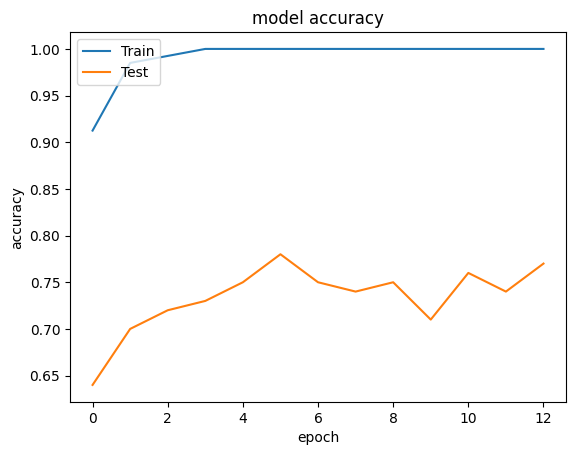

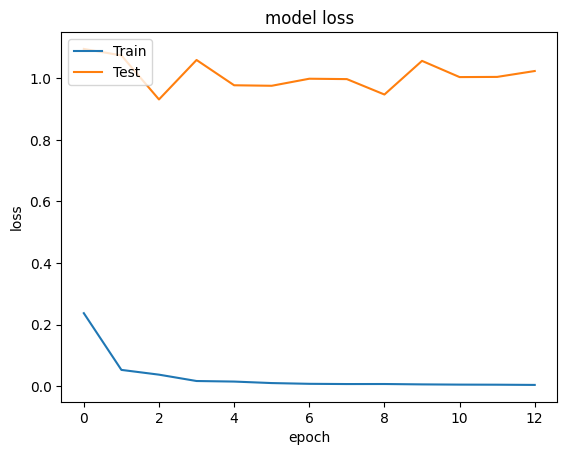

In [30]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Confusion Matrix and Classification Report

In [31]:
predictions = model.predict(X_test)
y_pred=np.argmax(predictions, axis=1)
y_test=np.argmax(Y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)
display_c_m = ConfusionMatrixDisplay(cm, display_labels=labels)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step 
[[11  1  0  2  1]
 [ 4  9  4  1  3]
 [ 0  0 17  2  1]
 [ 1  0  1 17  3]
 [ 0  1  3  0 18]]


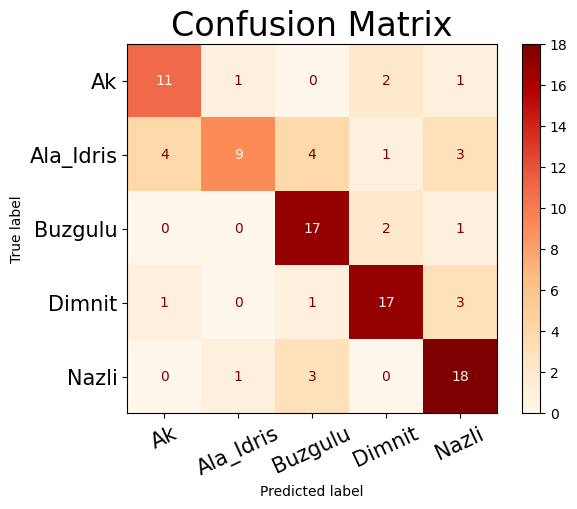

              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.82      0.43      0.56        21
           2       0.68      0.85      0.76        20
           3       0.77      0.77      0.77        22
           4       0.69      0.82      0.75        22

    accuracy                           0.72       100
   macro avg       0.73      0.72      0.71       100
weighted avg       0.73      0.72      0.71       100



In [32]:
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Confusion Matrix', fontsize=24)
plt.show()
print(classification_report(y_test, y_pred))